In [161]:
import pandas as pd

import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

import warnings
warnings.filterwarnings("ignore")

Reading

In [76]:
df = pd.read_csv("Data/index_archieve/security.csv", skiprows=2, encoding='cp1251', sep=";")

Preprocessing

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5489 entries, 0 to 5488
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BOARDID         5489 non-null   object 
 1   SECID           5489 non-null   object 
 2   TRADEDATE       5489 non-null   object 
 3   SHORTNAME       5489 non-null   object 
 4   NAME            5489 non-null   object 
 5   CLOSE           5489 non-null   object 
 6   OPEN            5254 non-null   object 
 7   HIGH            5263 non-null   object 
 8   LOW             5263 non-null   object 
 9   VALUE           5263 non-null   object 
 10  DURATION        1517 non-null   float64
 11  YIELD           1517 non-null   float64
 12  DECIMALS        5489 non-null   int64  
 13  CAPITALIZATION  3014 non-null   object 
 14  CURRENCYID      5489 non-null   object 
 15  DIVISOR         2554 non-null   object 
 16  TRADINGSESSION  5489 non-null   int64  
 17  VOLUME          0 non-null      f

In [77]:
df['TRADEDATE'] = pd.to_datetime(df['TRADEDATE'], format='%d.%m.%Y')
df.set_index('TRADEDATE', inplace=True)
df[['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VALUE']] = df[['OPEN', 'CLOSE', 'HIGH', 'LOW', 'VALUE']].apply(lambda x: x.str.replace(',', '.').astype(float))

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5489 entries, 2002-01-03 to 2023-12-20
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   BOARDID         5489 non-null   object 
 1   SECID           5489 non-null   object 
 2   SHORTNAME       5489 non-null   object 
 3   NAME            5489 non-null   object 
 4   CLOSE           5489 non-null   float64
 5   OPEN            5254 non-null   float64
 6   HIGH            5263 non-null   float64
 7   LOW             5263 non-null   float64
 8   VALUE           5263 non-null   float64
 9   DURATION        1517 non-null   float64
 10  YIELD           1517 non-null   float64
 11  DECIMALS        5489 non-null   int64  
 12  CAPITALIZATION  3014 non-null   object 
 13  CURRENCYID      5489 non-null   object 
 14  DIVISOR         2554 non-null   object 
 15  TRADINGSESSION  5489 non-null   int64  
 16  VOLUME          0 non-null      float64
dtypes: float64(8), 

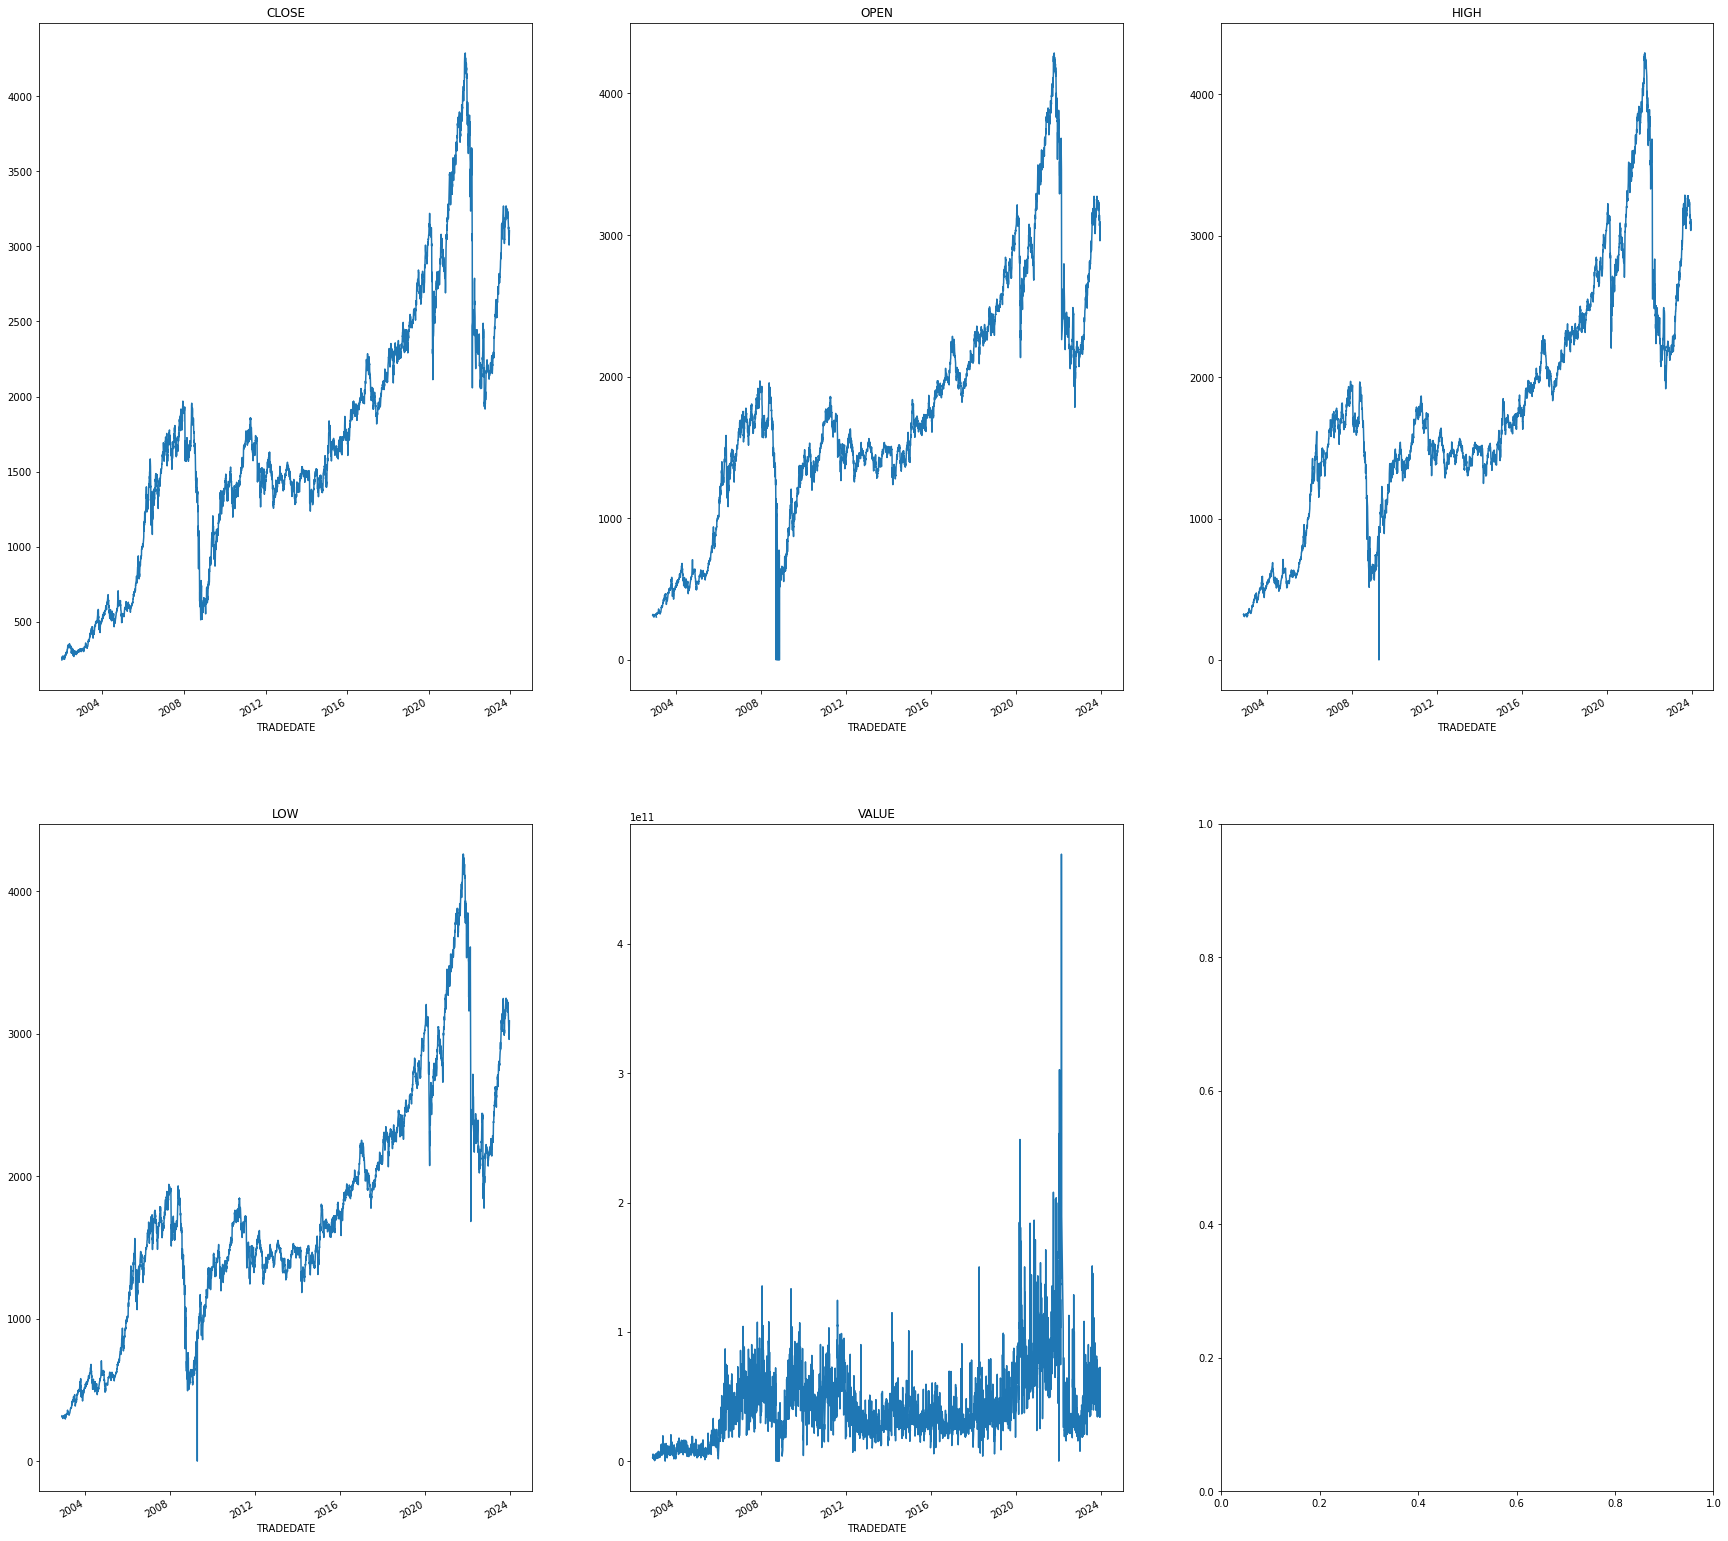

In [78]:
# numeric_columns = df.select_dtypes(include=np.number).columns
columns_to_plot = ['CLOSE', 'OPEN', 'HIGH', 'LOW', 'VALUE']

fig, axes = plt.subplots(nrows=len(columns_to_plot)//2, ncols=3, figsize=(30, 6 * len(columns_to_plot)))

for i, column in enumerate(columns_to_plot):
    df[column].plot(ax=axes[i//3][i%3], label=column)
    axes[i//3][i%3].set_title(column)

plt.show()

Подбор гиперпараметров для модели

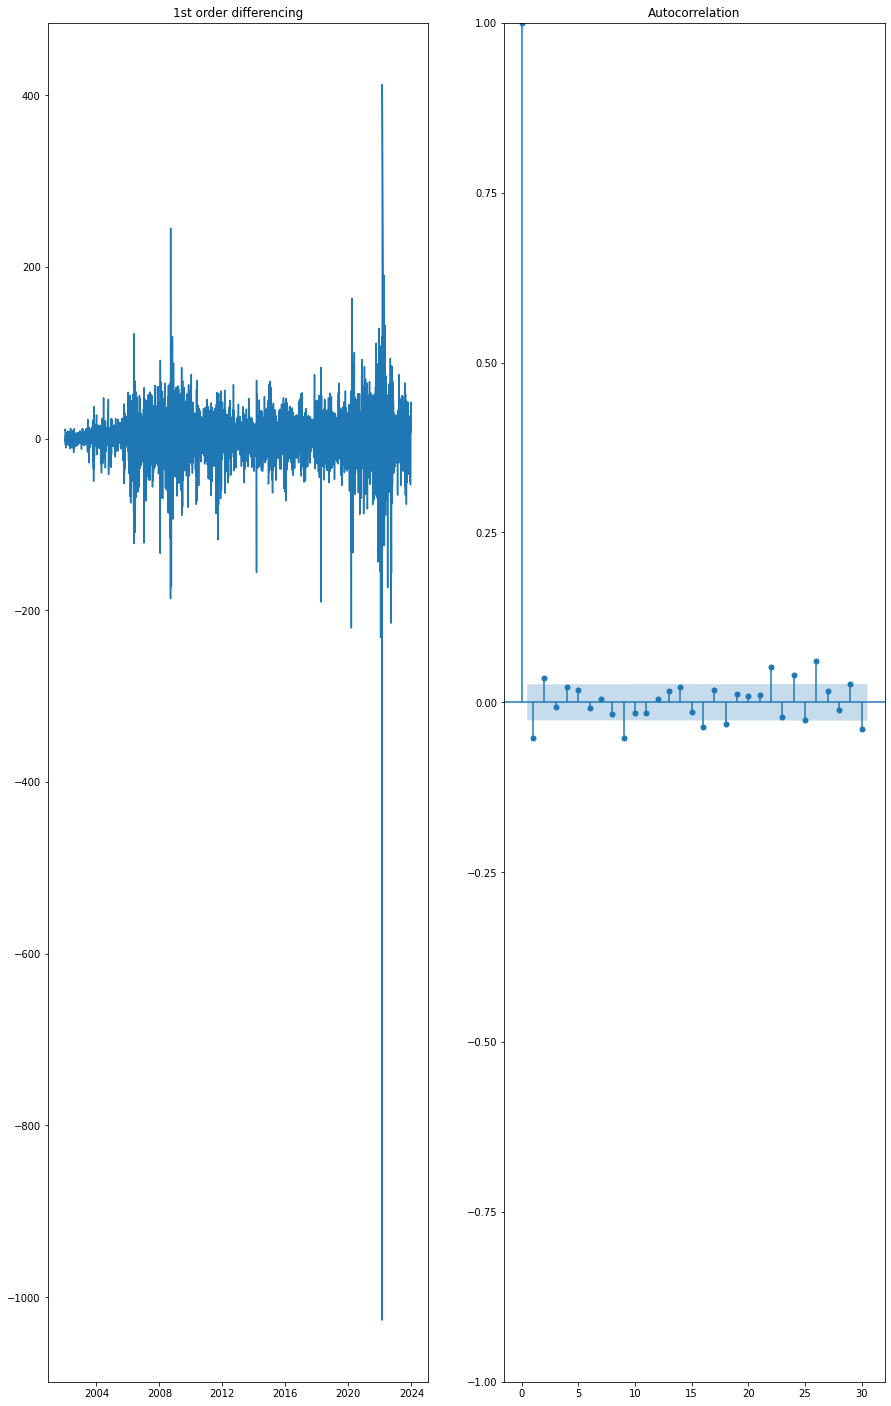

ADF Statistic: -12.654657627559146
p-value: 1.344898241031796e-23
Critical Values: {'1%': -3.4315484571510573, '5%': -2.862069598267727, '10%': -2.5670519041148756}
Is the time series stationary? True


In [147]:
# Проверка стационарности временного ряда через критерий Дики-Фуллера
def test_stationarity(timeseries):
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is the time series stationary?', result[1] < 0.05)

fig = plt.figure(figsize=(15, 25))
ax1 = fig.add_subplot(121)
ax1.set_title('1st order differencing')
ax1.plot(df.CLOSE.diff().dropna()) # создание стационарного временного ряда 

ax2 = fig.add_subplot(122)
plot_acf(df.CLOSE.diff().dropna(), lags=30, ax=ax2)
# plot_pacf(df['CLOSE_diff'], lags=30)
plt.show()

# Проверка стационарности временного ряда
test_stationarity(df['CLOSE_diff'])

Model 

In [81]:
len(df)

5489

p - 1, так как на графике автокорреляции первое значение является самым значимым

d - количество дифференцирований для стационарности ряда, которое определяется через критерий Дики Фуллера 

q - определяется по количеству статистически значимых значений автокорреляции с графика ACF 

In [162]:
days_to_predict = 20

model = ARIMA(df.CLOSE[:days_to_predict], order=(2, 1, 2))  # (p, d, q)
model_fit = model.fit()

print(model_fit.summary())

forecast = model_fit.forecast(steps=10)  
print(forecast)

                               SARIMAX Results                                
Dep. Variable:                  CLOSE   No. Observations:                   20
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 -56.279
Date:                Fri, 29 Dec 2023   AIC                            122.557
Time:                        13:20:36   BIC                            127.279
Sample:                             0   HQIC                           123.356
                                 - 20                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4671      0.084     17.514      0.000       1.303       1.631
ar.L2         -0.9460      0.109     -8.666      0.000      -1.160      -0.732
ma.L1         -1.7044      7.308     -0.233      0.8

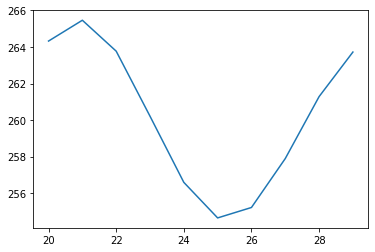

In [163]:
plt.ticklabel_format(axis='y', style='plain')
forecast.plot()
plt.show()

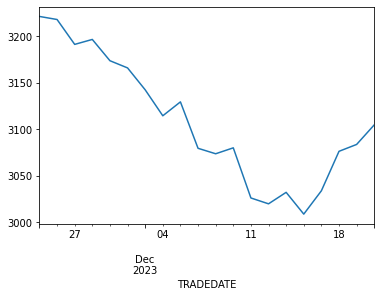

In [164]:
df.iloc[-days_to_predict:].CLOSE.plot()
plt.show()

МУСОРКА

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Создадим модель ARIMA и обучим её на данных
model = ARIMA(df, order=(1, 1, 1))  # Здесь (1, 1, 1) - порядок модели ARIMA (p, d, q)
model_fit = model.fit()

# Выведем статистику обученной модели
print(model_fit.summary())

# Прогнозирование с использованием обученной модели
forecast = model_fit.forecast(steps=10)  # Здесь 10 - количество шагов для прогнозирования
print(forecast)

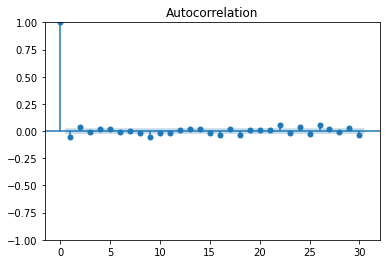

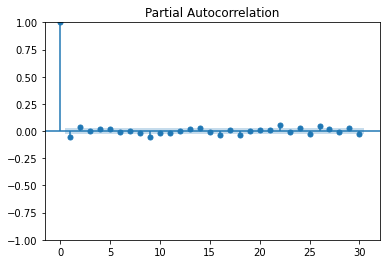

ADF Statistic: -12.654657627559146
p-value: 1.344898241031796e-23
Critical Values: {'1%': -3.4315484571510573, '5%': -2.862069598267727, '10%': -2.5670519041148756}
Is the time series stationary? True


In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

# Проверка стационарности временного ряда
def test_stationarity(timeseries):
    # Критерий Дики-Фуллера
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])
    print('Is the time series stationary?', result[1] < 0.05)

# Создание стационарного временного ряда (если необходимо)
df['CLOSE_diff'] = df['CLOSE'].diff()
df['CLOSE_diff'].fillna(0, inplace=True)

# Построение ACF и PACF графиков
plot_acf(df['CLOSE_diff'], lags=30)
plot_pacf(df['CLOSE_diff'], lags=30)
plt.show()

# Проверка стационарности временного ряда
test_stationarity(df['CLOSE_diff'])

<AxesSubplot: xlabel='TRADEDATE'>

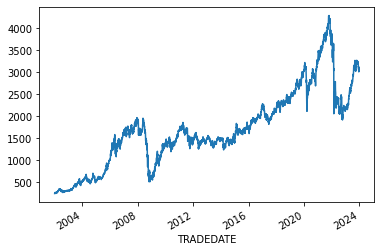

In [49]:
df['CLOSE'].plot()